In [2]:
%load_ext autoreload
%autoreload 2

from PSO import PSO
import torch
from torch import nn
from shadow_attacker_optimized import ShadowAttack

## Quick Testing


Test PSO


In [15]:
# Params
batch_size = 10
n_particles = 10
dim = 2
c1 = 2.0
c2 = 2.0
w = 1.0
num_iters = 10

pos_lb = torch.zeros(dim)
pos_ub = torch.ones(dim) * 255.0
pos_constraint = torch.stack((pos_lb, pos_ub), dim=0)
speed_lim = 30.0
vel_lb = -torch.ones(dim) * speed_lim
vel_ub = torch.ones(dim) * speed_lim
vel_constraint = torch.stack((vel_lb, vel_ub), dim=0)

# Arbitrary model
model = nn.Sequential(
    nn.Linear(in_features=dim, out_features=1),
    nn.ReLU(),
)


# Define particle's loss function
def cost_fn(batch_particles: torch.Tensor):
    # Returns negative sum of values, so optimal would be (255,255, ...)
    batch_particles_flat = batch_particles.flatten(start_dim=1)  # Shape (N, *)
    return -torch.sum(batch_particles_flat, dim=1)


# Create PSO
optimizer = PSO(
    batch_size=batch_size,
    num_iters=num_iters,
    n_particles=n_particles,
    dim=dim,
    c1=c1,
    c2=c2,
    w=w,
    pos_constraint=pos_constraint,
    vel_constraint=vel_constraint,
)

batch_best_cost, batch_best_particle = optimizer.optimize(cost_fn=cost_fn)

print(batch_best_cost, batch_best_particle)

100%|██████████| 10/10 [00:00<00:00, 2246.43it/s]

tensor([-510., -510., -510., -510., -510., -510., -510., -510., -510., -510.],
       device='cuda:0') tensor([[255., 255.],
        [255., 255.],
        [255., 255.],
        [255., 255.],
        [255., 255.],
        [255., 255.],
        [255., 255.],
        [255., 255.],
        [255., 255.],
        [255., 255.]], device='cuda:0')


Testing shadow attacks


In [56]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to display the tensor
def display_tensor_images(tensor):
    """
    Display a tensor of shape (batch_size, sequence_length, 3, height, width)
    as a grid of images with rows as batch indices and columns as sequence indices.
    """
    batch_size, seq_length, channels, height, width = tensor.shape

    # Create a figure with batch_size rows and seq_length columns
    fig, axes = plt.subplots(batch_size, seq_length, figsize=(seq_length * 3, batch_size * 3))
    fig.suptitle("Tensor Visualization: Rows=Batch, Columns=Sequence", fontsize=16)

    # Ensure axes is 2D even for batch_size=1 or seq_length=1
    axes = np.array(axes).reshape(batch_size, seq_length)

    for i in range(batch_size):  # Loop over batch
        for j in range(seq_length):  # Loop over sequence
            # Extract the image for batch `i` and sequence `j`
            img = tensor[i, j].cpu().permute(1, 2, 0).numpy()  # Convert to (H, W, C) for visualization

            # Normalize image to [0, 1] if necessary
            img = (img - img.min()) / (img.max() - img.min())

            # Display the image
            axes[i, j].imshow(img)
            axes[i, j].axis("off")  # Hide axes

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust for suptitle
    plt.show()

100%|██████████| 100/100 [00:05<00:00, 17.89it/s]


tensor([0.2252, 0.2252], device='cuda:0', dtype=torch.float64)
torch.Size([2, 4, 3, 200, 300])


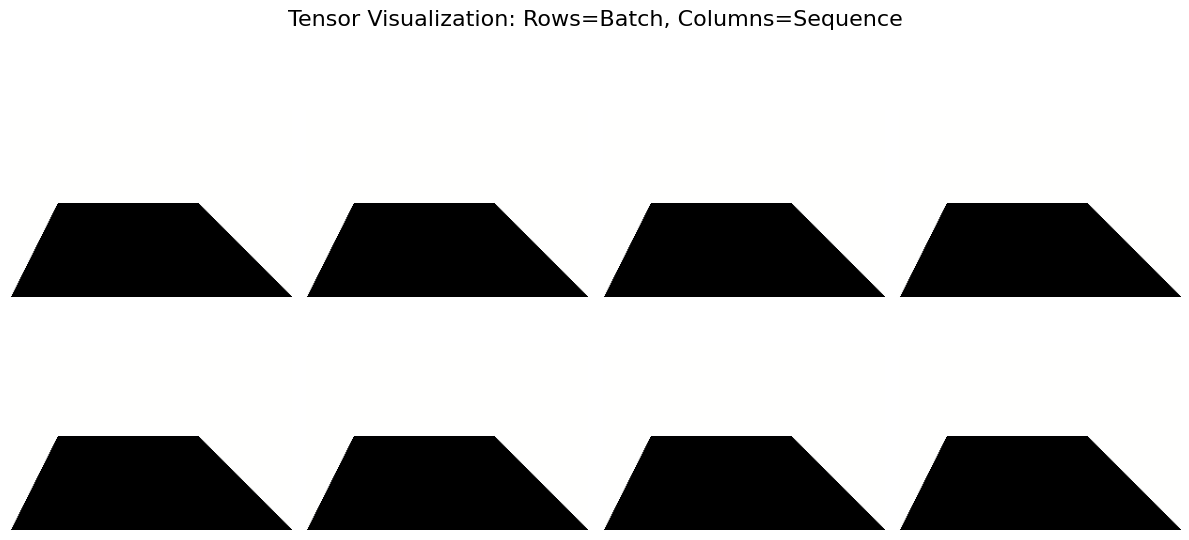

In [55]:
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X, *args):
        # X of shape (batch_size, seq_length, 3, H, W)
        # Return the first channel of the first image from the sequence.
        return X[:, 0, 0].unsqueeze(1), _, _


# Since loss function in shadow attack is to maximize L1 difference, my input X is just white image, then it will try to create the largest shadow as possible.
model = DummyModel()
X = torch.ones((2, 4, 3, 200, 300), dtype=float)
garbage = torch.ones((2, 2))
model_inputs = [X, garbage]
attacker = ShadowAttack(model=model)
attacker.PSO_params["num_iters"] = 100
adv_loss, Xp = attacker.generate_attack(model_inputs)
print(adv_loss)
print(Xp.shape)
display_tensor_images(Xp)